In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib.widgets import Button
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the data from TrainData.csv
train_data = pd.read_csv("TrainData.csv")

train_data.head()

TIMESTAMP     POWER       U10       V10      WS10      U100      V100  \
0  20120101 1:00  0.273678  0.534894 -3.660243  3.699120  0.765355 -4.486657   
1  20120101 2:00  0.086796  0.330813 -2.676430  2.696797  0.469875 -3.213752   
2  20120101 3:00  0.006811 -0.065839 -2.029072  2.030140 -0.020893 -2.418119   
3  20120101 4:00  0.018646 -0.419549 -1.799090  1.847362 -0.444867 -2.149654   
4  20120101 5:00  0.034812 -0.754224 -1.661526  1.824698 -0.838274 -1.991829   

      WS100  
0  4.551468  
1  3.247920  
2  2.418209  
3  2.195203  
4  2.161038

# Through this project assignment, we only use weather data forecasting at 10m above ground level

In [3]:
# Removing the columns related to ws100
train_data = train_data.drop(['WS100', 'U100', 'V100'], axis=1)

In [4]:
# Displaying main information about the dataset
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16080 entries, 0 to 16079
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TIMESTAMP  16080 non-null  object 
 1   POWER      16080 non-null  float64
 2   U10        16080 non-null  float64
 3   V10        16080 non-null  float64
 4   WS10       16080 non-null  float64
dtypes: float64(4), object(1)
memory usage: 628.3+ KB


In [5]:
# Convert TIMESTAMP to datetime and set as index
train_data['TIMESTAMP'] = pd.to_datetime(train_data['TIMESTAMP'])
train_data = train_data.set_index('TIMESTAMP')
train_data.head()

POWER       U10       V10      WS10
TIMESTAMP                                                  
2012-01-01 01:00:00  0.273678  0.534894 -3.660243  3.699120
2012-01-01 02:00:00  0.086796  0.330813 -2.676430  2.696797
2012-01-01 03:00:00  0.006811 -0.065839 -2.029072  2.030140
2012-01-01 04:00:00  0.018646 -0.419549 -1.799090  1.847362
2012-01-01 05:00:00  0.034812 -0.754224 -1.661526  1.824698

In [6]:
# Describing the dataset, styling the output and rounding the values
train_data.describe().round(4).drop(index='count').style.format(na_rep='-')

In [7]:
# Check for missing values
missing_values = train_data.isnull().sum()
missing_values

POWER    0
U10      0
V10      0
WS10     0
dtype: int64



# Exploratory Data Analysis

### Data Visualization

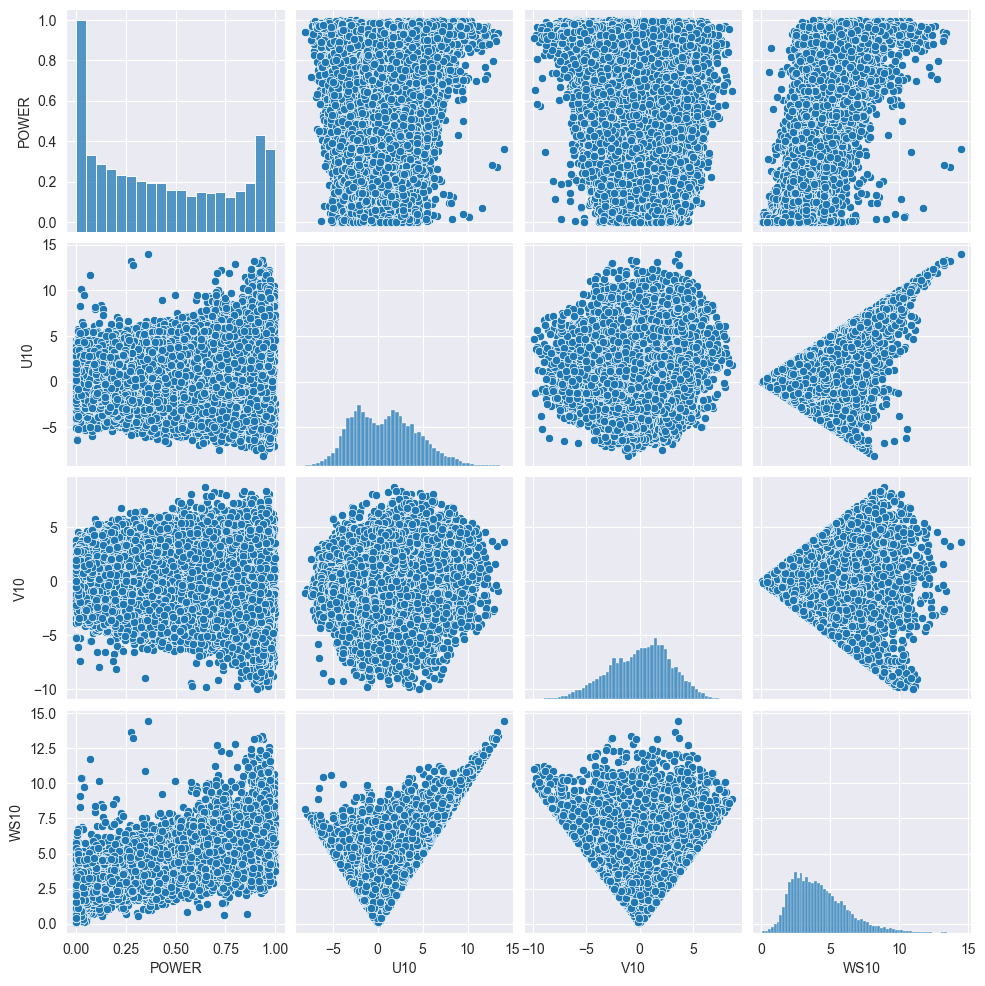

In [8]:
sns.pairplot(train_data)

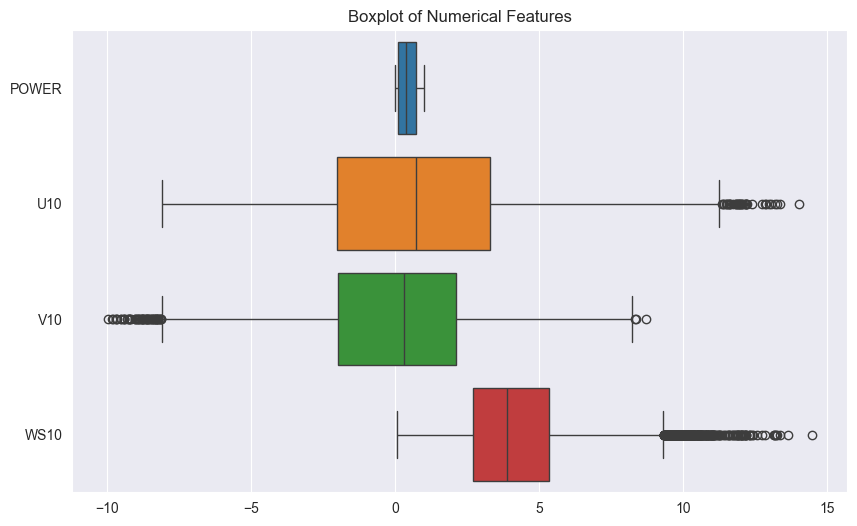

In [9]:
# Using boxplot to visualize the distribution of numerical data
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_data, orient='h')
plt.title('Boxplot of Numerical Features')
plt.show()

### Distribution of the target variable and WS10

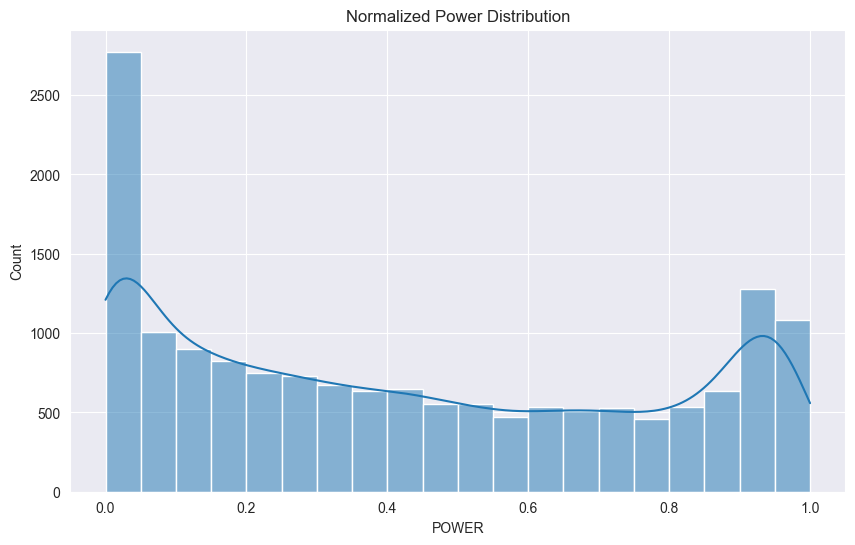

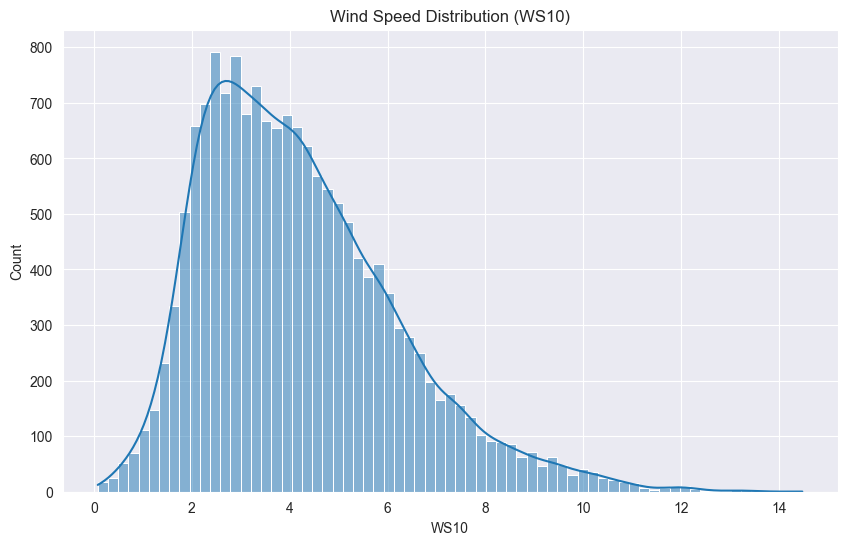

In [10]:
# Displaying the distribution of the target variable and WS10
plt.figure(figsize=(10, 6))
sns.histplot(train_data['POWER'], kde=True)
plt.title('Normalized Power Distribution')
plt.show()
plt.figure(figsize=(10, 6))
sns.histplot(train_data['WS10'], kde=True)
plt.title('Wind Speed Distribution (WS10)')
plt.show()


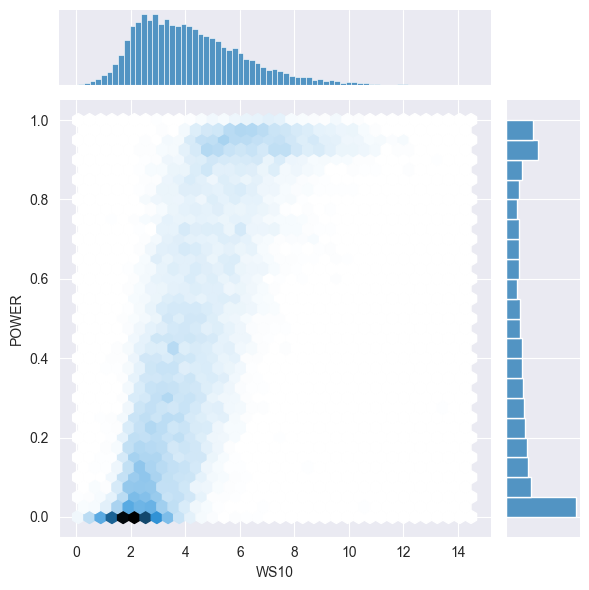

In [11]:
import seaborn as sns
sns.jointplot(x='WS10', y='POWER', data=train_data, kind='hex')

### Feature Engineering

In [12]:
# Convert index to datetime
train_data.index = pd.to_datetime(train_data.index)
train_data['TIMESTAMP'] = train_data.index

# Extracting wanted time features
train_data['hour'] = train_data['TIMESTAMP'].dt.hour
train_data['day'] = train_data['TIMESTAMP'].dt.day
train_data['day_of_week'] = train_data['TIMESTAMP'].dt.dayofweek  # Monday=0, Sunday=6
train_data['month'] = train_data['TIMESTAMP'].dt.month
train_data['year'] = train_data['TIMESTAMP'].dt.year
train_data['week'] = train_data['TIMESTAMP'].dt.isocalendar().week

# Filter by year
train_data_2012 = train_data[train_data['year'] == 2012]
train_data_2013 = train_data[train_data['year'] == 2013]

In [13]:
print(train_data.columns.tolist())

['POWER', 'U10', 'V10', 'WS10', 'TIMESTAMP', 'hour', 'day', 'day_of_week', 'month', 'year', 'week']


### Visualizing the data for target variable

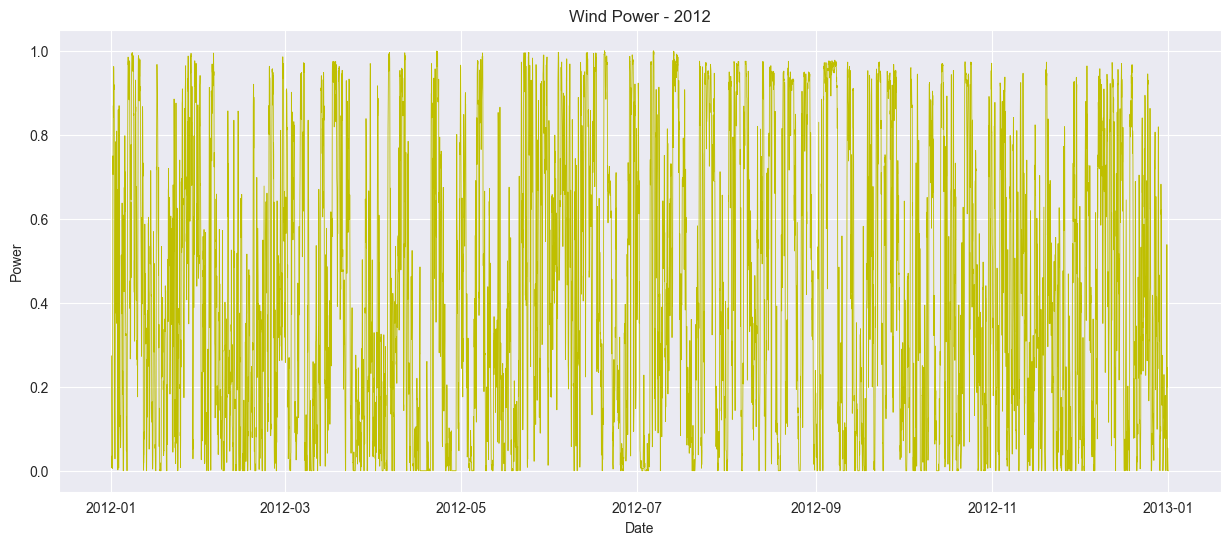

In [14]:
# Plot the data for 2012
plt.figure(figsize=(15, 6))
plt.plot(train_data_2012.index, train_data_2012['POWER'], label='Power', color='y', linewidth=0.6)
plt.title('Wind Power - 2012')
plt.xlabel('Date')
plt.ylabel('Power')
plt.grid(True)
plt.show()

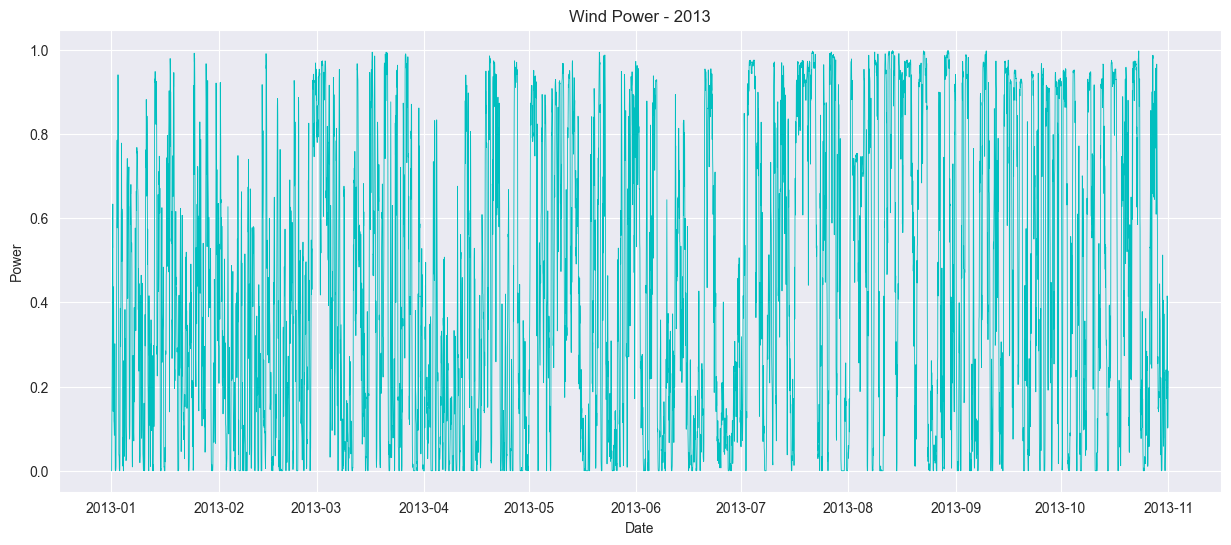

In [15]:
# Plot the data for 2013
plt.figure(figsize=(15, 6))
plt.plot(train_data_2013.index, train_data_2013['POWER'], label='Power', color='c', linewidth=0.6)
plt.title('Wind Power - 2013')
plt.xlabel('Date')
plt.ylabel('Power')
plt.grid(True)
plt.show()


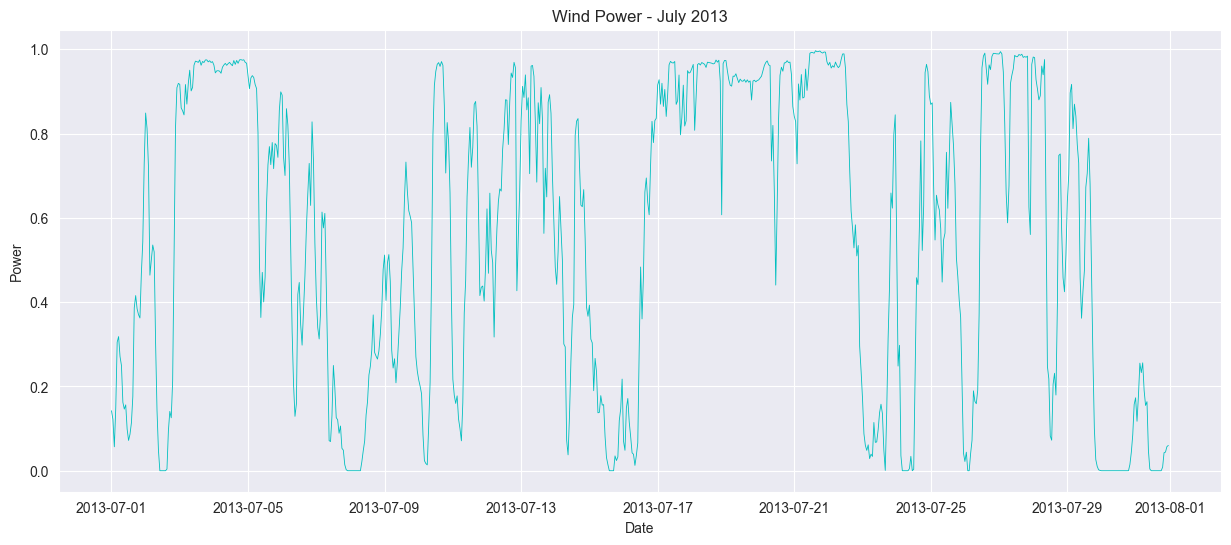

In [16]:
# Plot the power data for july 2013
plt.figure(figsize=(15, 6))
plt.plot(train_data_2013['POWER']['2013-07'], label='Power', color='c', linewidth=0.6)
plt.title('Wind Power - July 2013')
plt.xlabel('Date')
plt.ylabel('Power')
plt.grid(True)
plt.show()


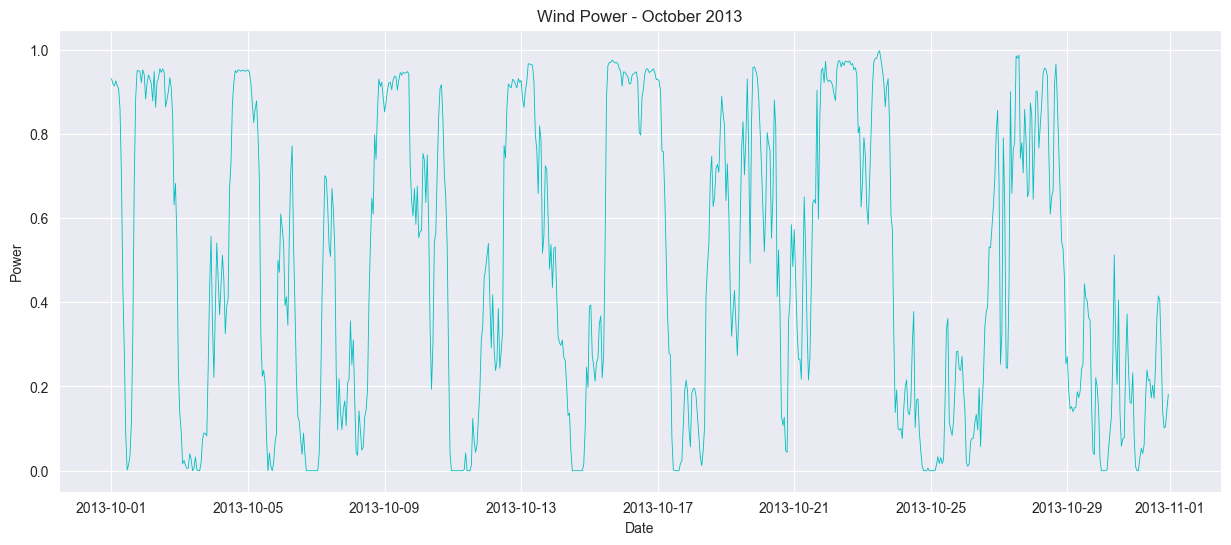

In [17]:
# Plotting the power data for October 2013
plt.figure(figsize=(15, 6))
plt.plot(train_data_2013['POWER']['2013-10'], label='Power', color='c', linewidth=0.6)
plt.title('Wind Power - October 2013')
plt.xlabel('Date')
plt.ylabel('Power')
plt.grid(True)
plt.show()

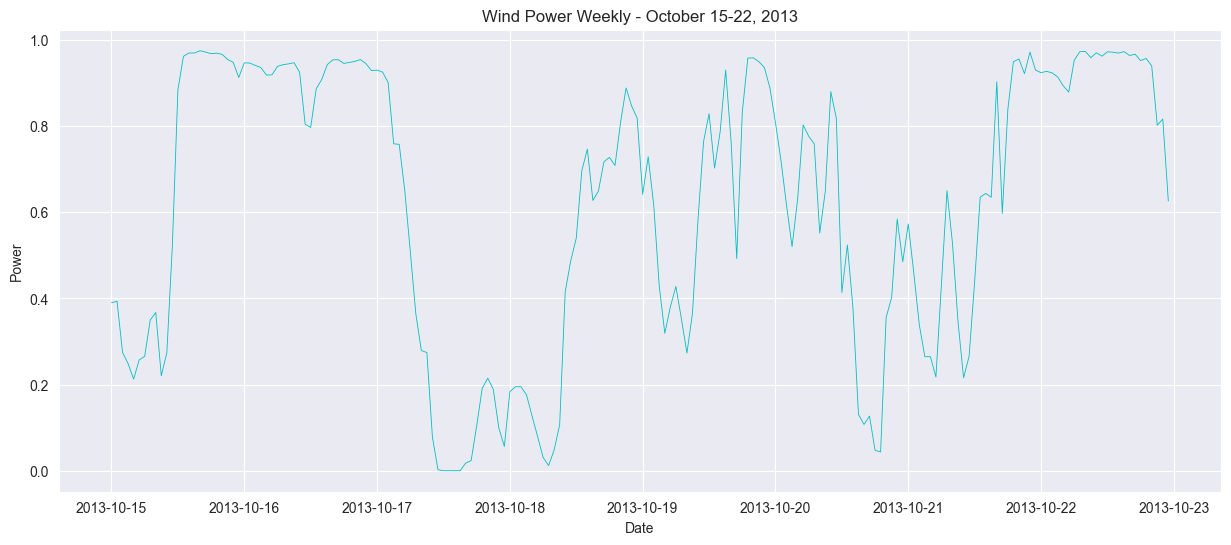

In [18]:
# plotting the power data for a random week
plt.figure(figsize=(15, 6))
plt.plot(train_data_2013['POWER']['2013-10-15':'2013-10-22'], label='Power', color='c', linewidth=0.6)
plt.title('Wind Power Weekly - October 15-22, 2013')
plt.xlabel('Date')
plt.ylabel('Power')
plt.grid(True)
plt.show()

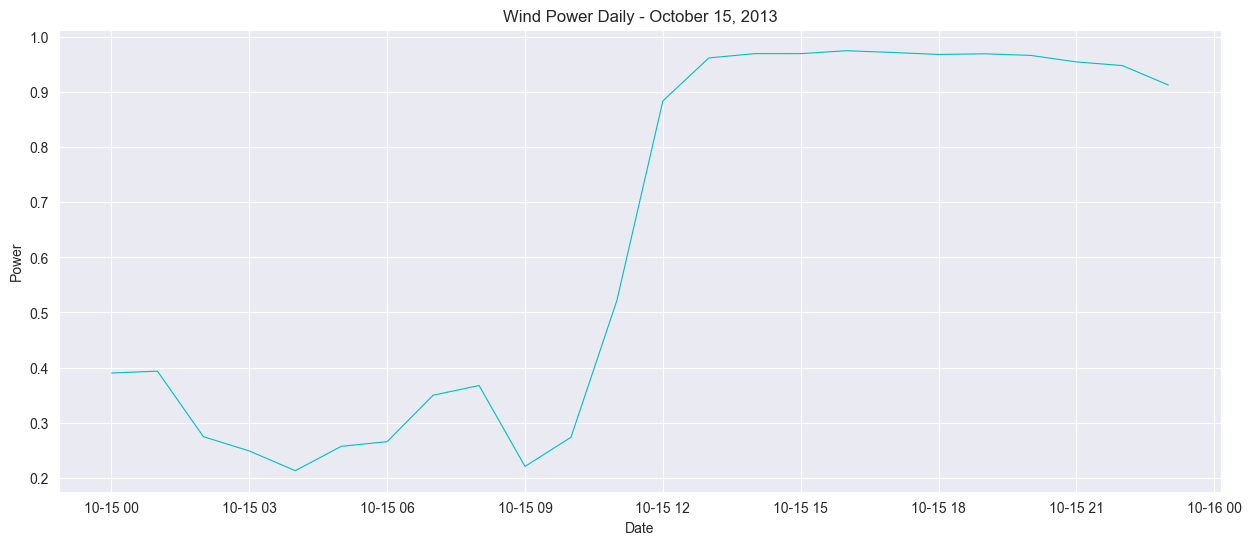

In [19]:
# plotting the power data for one random day
plt.figure(figsize=(15, 6))
plt.plot(train_data_2013['POWER']['2013-10-15'], label='Power', color='c', linewidth=0.8)
plt.title('Wind Power Daily - October 15, 2013')
plt.xlabel('Date')
plt.ylabel('Power')
plt.grid(True)
plt.show()

### Seasonal Decomposition of time series data

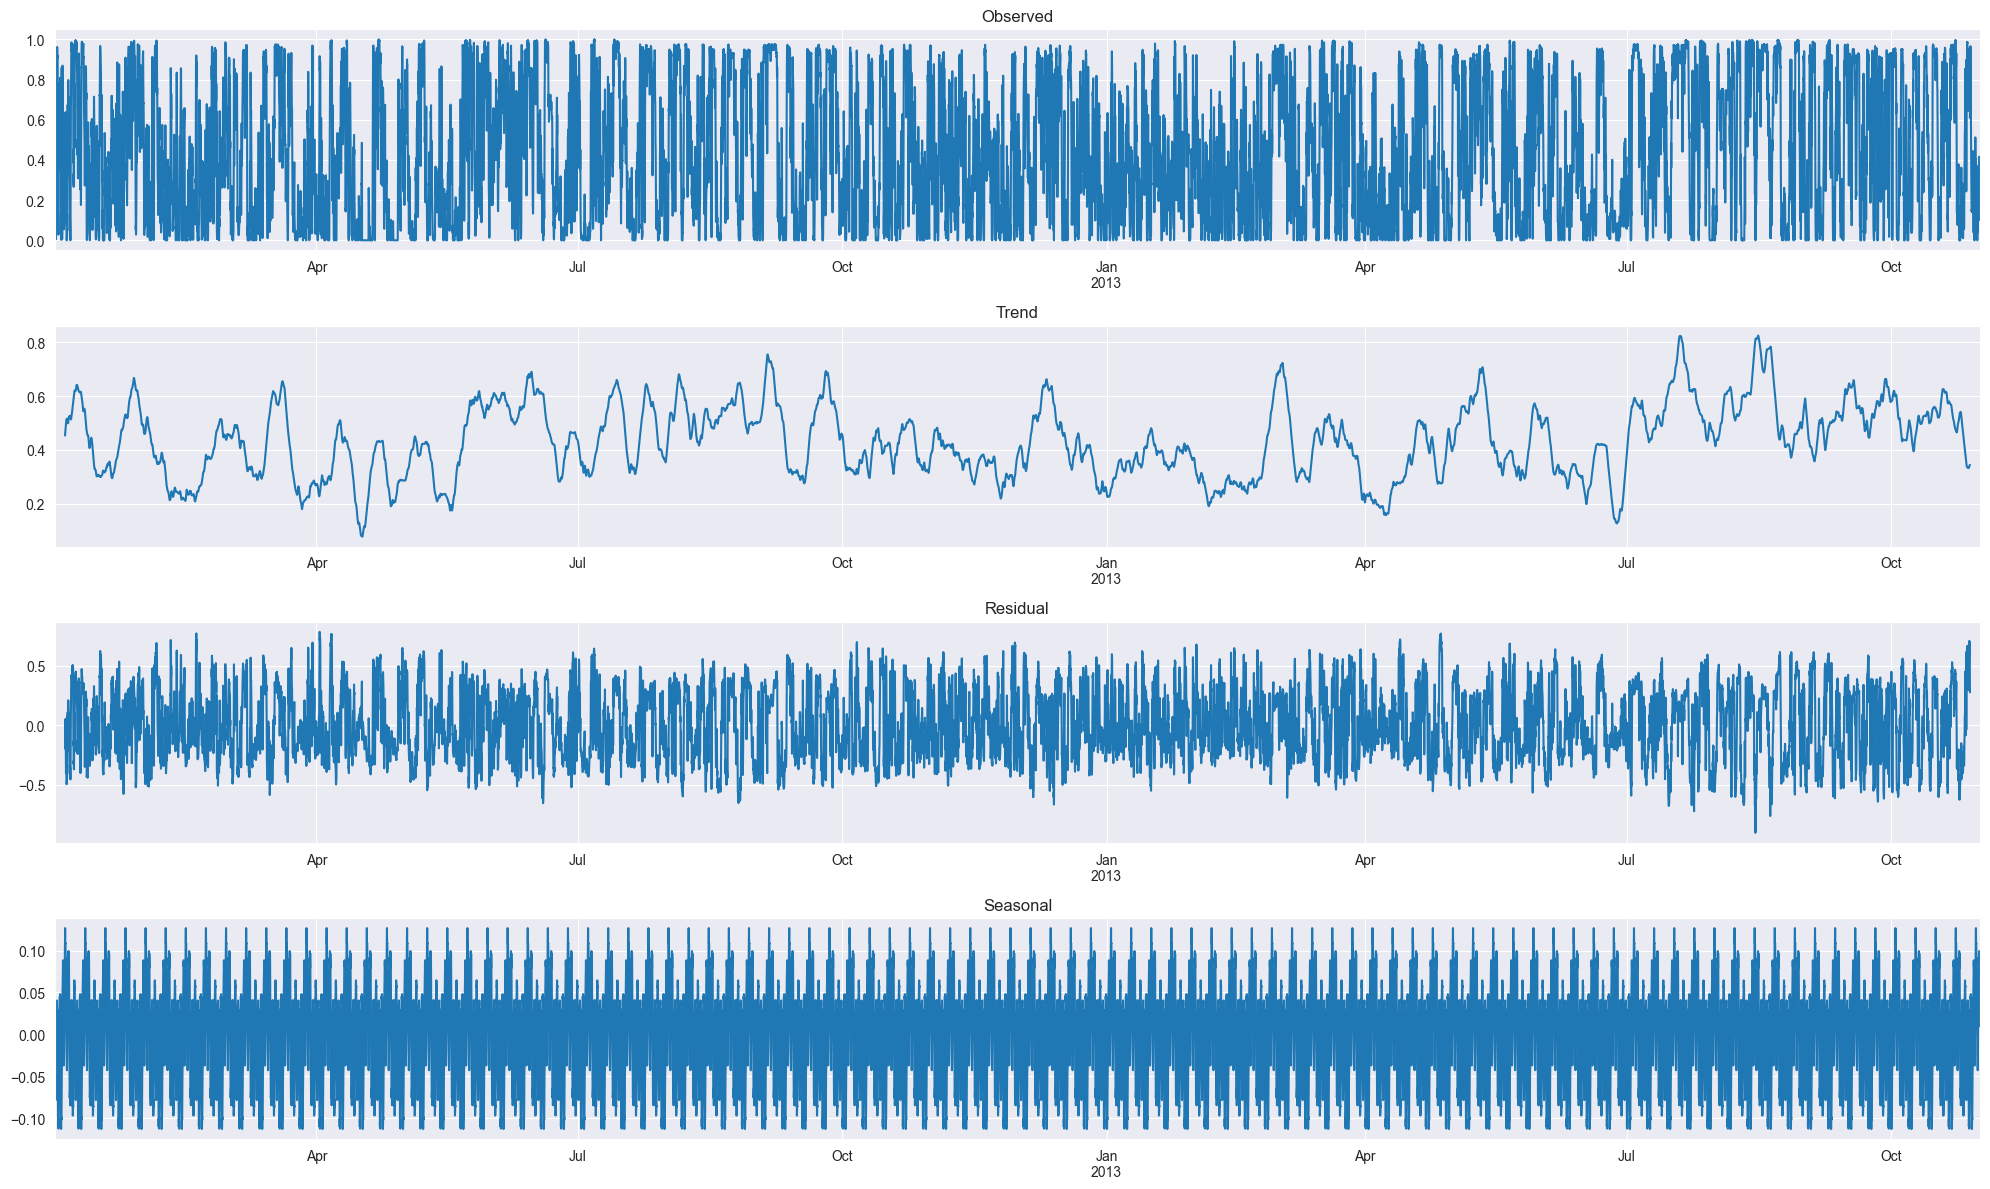

In [20]:
res = sm.tsa.seasonal_decompose(train_data['POWER'], model='additive', period=24*7)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Observed')
ax1.set_xlabel('')
res.trend.plot(ax=ax2, title='Trend')
ax2.set_xlabel('')
res.resid.plot(ax=ax3, title='Residual')
ax3.set_xlabel('')
res.seasonal.plot(ax=ax4, title='Seasonal')
ax4.set_xlabel('')
plt.tight_layout()
plt.show()

### Autocorrelation and Partial Autocorrelation

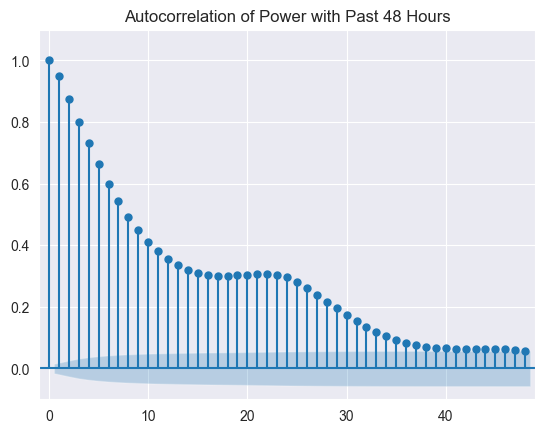

In [21]:
fig, ax = plt.subplots()
plot_acf(train_data['POWER'], lags=48, ax=ax, title='Autocorrelation of Power with Past 48 Hours')
ax.set_xlim(-1, 49)
ax.set_ylim(-0.1, 1.1)
plt.show()

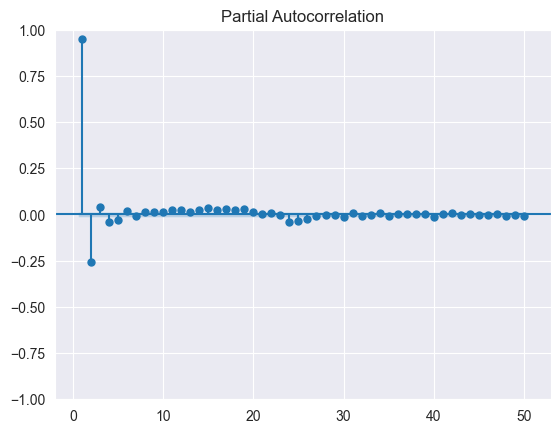

In [22]:
plot_pacf(train_data['POWER'], lags=50, zero=False)
plt.show()

### Perform Augmented Dickey-Fuller test to check for stationarity

In [23]:
result = adfuller(train_data['POWER'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -16.34403865870787
p-value: 2.976529639352272e-29
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


### Rolling Mean

In [24]:
# Create a datetime index for hourly data
train_data = train_data.reset_index(drop=True)
train_data['TIMESTAMP'] = pd.date_range(start='2012-01-01', periods=len(train_data), freq='H')
train_data = train_data.set_index('TIMESTAMP')

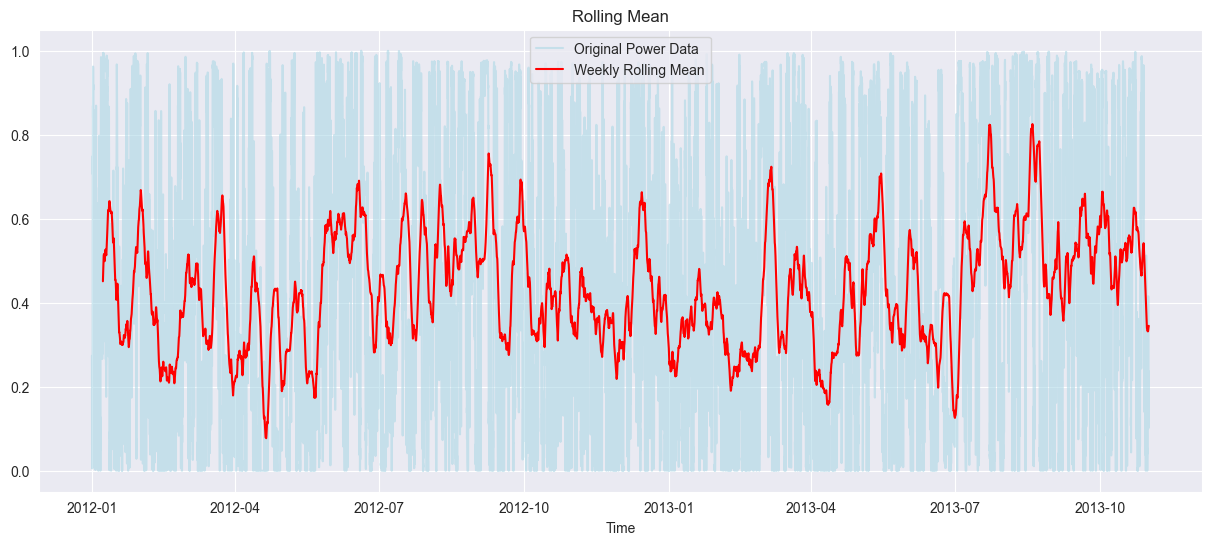

In [25]:
# Calculate rolling mean
rolling_mean = train_data['POWER'].rolling(window=24*7).mean()

plt.figure(figsize=(15, 6))
plt.plot(train_data.index, train_data['POWER'], color='lightblue', alpha=0.6, label='Original Power Data')
plt.plot(train_data.index, rolling_mean, color='red', linewidth=1.5, label='Weekly Rolling Mean')
plt.title('Rolling Mean')
plt.xlabel('Time')
plt.legend()
plt.show()

### Visualizing the Power by month using a box plot

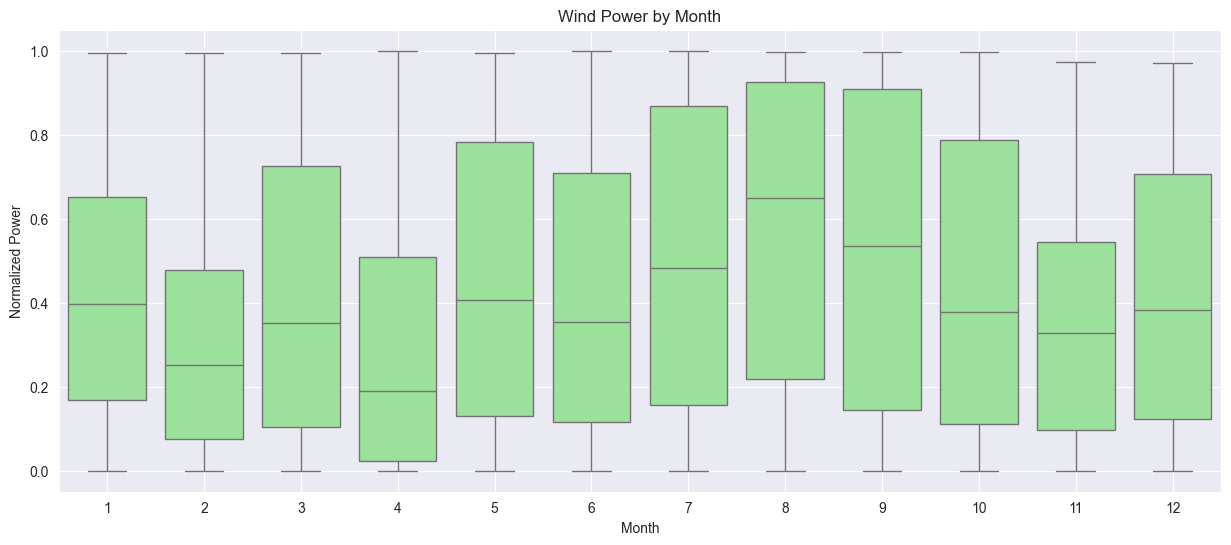

In [26]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=train_data, x='month', y='POWER', color='lightgreen')
plt.title('Wind Power by Month')
plt.xlabel('Month')
plt.ylabel('Normalized Power')
plt.grid(True)

### Visualizing the Power by week using a bar plot

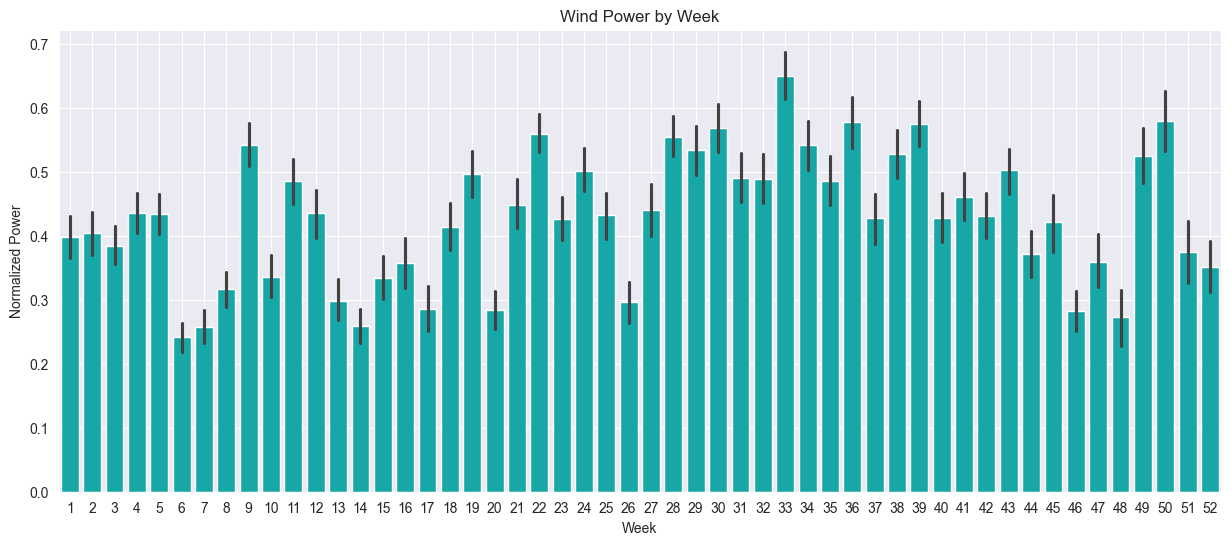

In [27]:
plt.figure(figsize=(15, 6))
sns.barplot(data=train_data, x='week', y='POWER', color='c')
plt.title('Wind Power by Week')
plt.xlabel('Week')
plt.ylabel('Normalized Power')
plt.grid(True)
plt.show()

### Visualizing the Power by day of the week using a bar plot

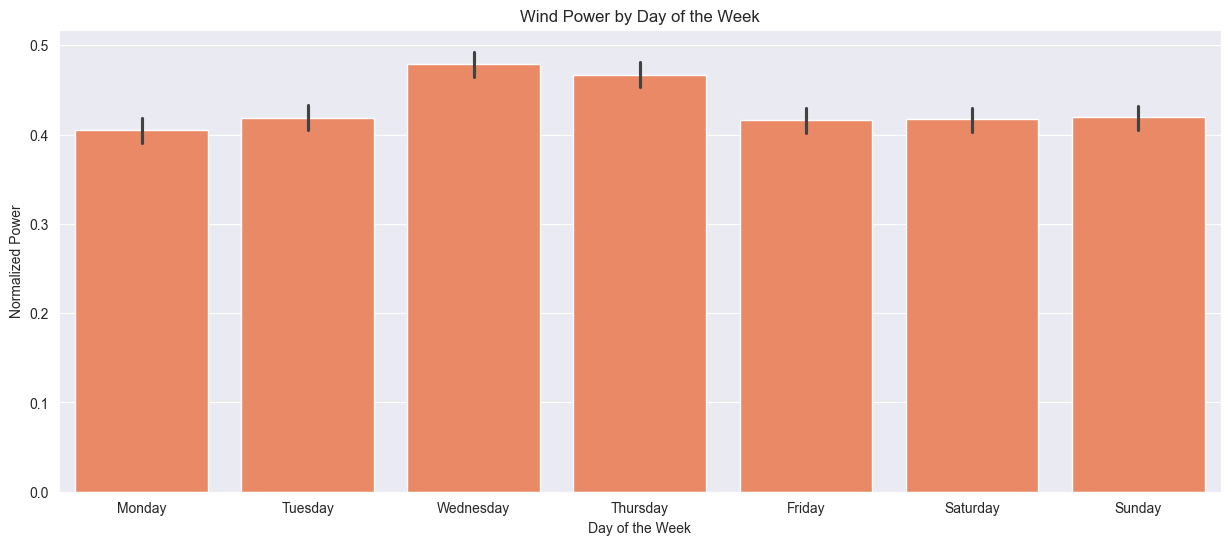

In [28]:
plt.figure(figsize=(15, 6))
sns.barplot(data=train_data, x='day_of_week', y='POWER', color='coral')
plt.title('Wind Power by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Normalized Power')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

In [29]:
train_data.index = pd.to_datetime(train_data.index)
train_data['TIMESTAMP'] = train_data.index

### Plot U10, V10 and WS10 over time

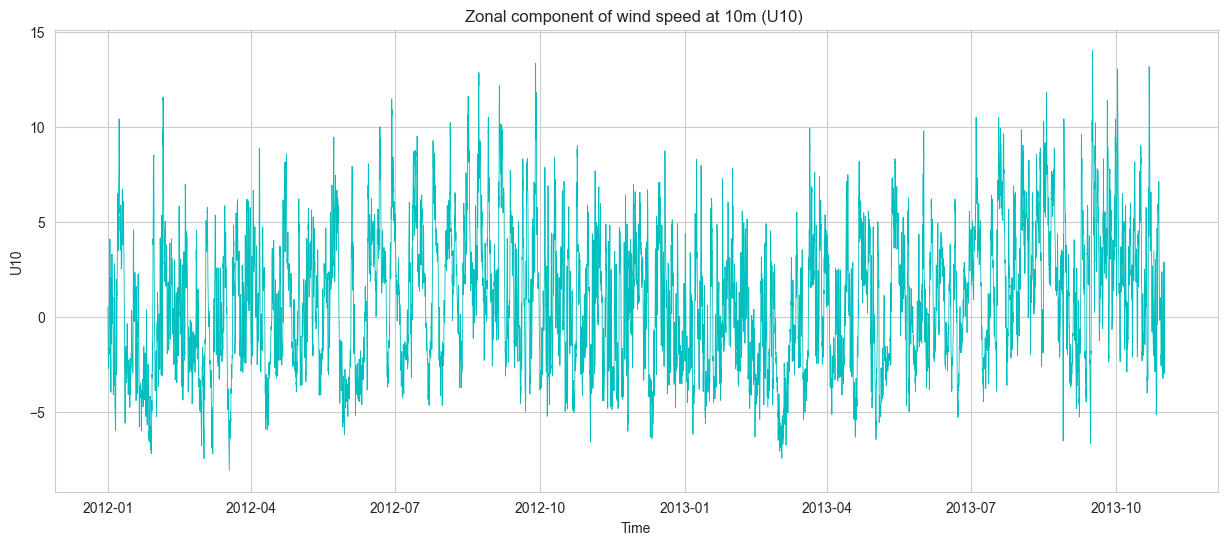

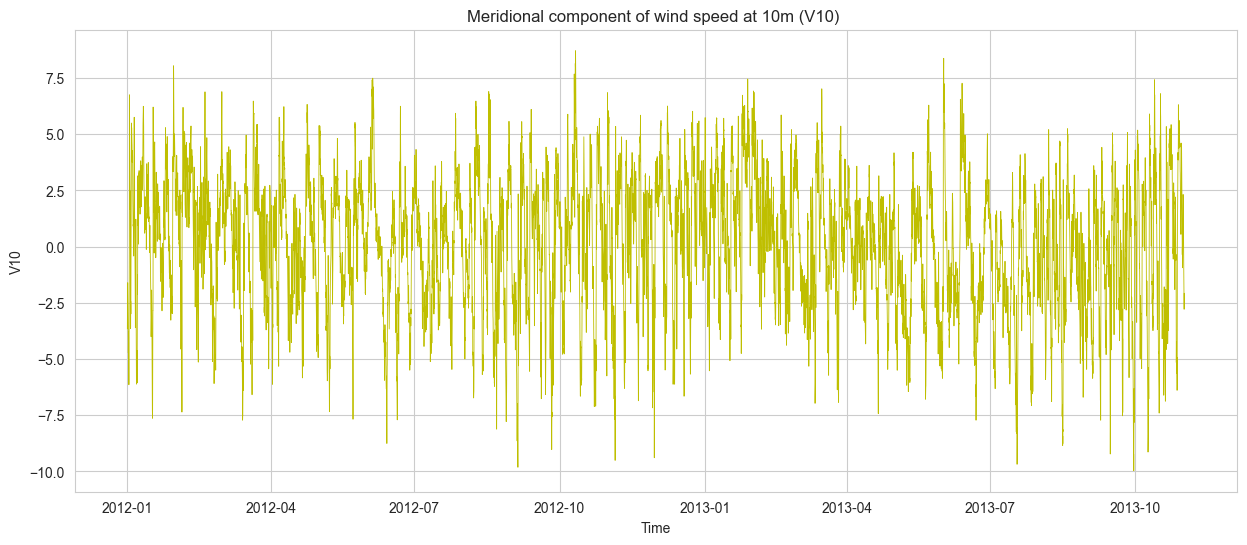

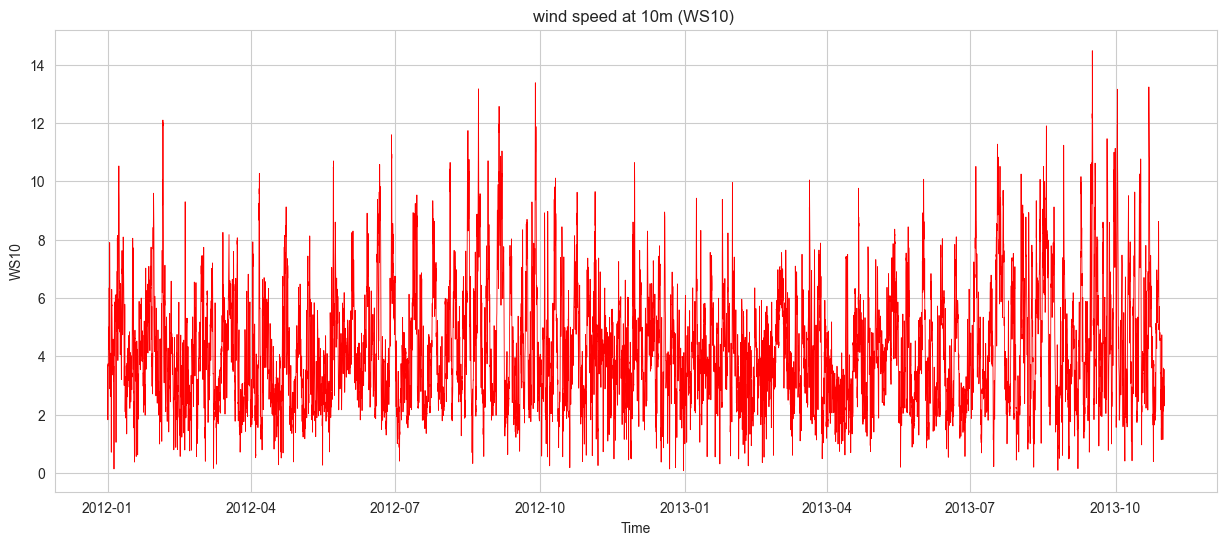

In [39]:
# U10
plt.figure(figsize=(15, 6))
plt.plot(train_data['TIMESTAMP'], train_data['U10'], color='c', linewidth=0.6)
plt.title('Zonal component of wind speed at 10m (U10) ')
plt.xlabel('Time')
plt.ylabel('U10')
plt.grid(True)
plt.show()


# V10
plt.figure(figsize=(15, 6))
plt.plot(train_data['TIMESTAMP'], train_data['V10'], color='y', linewidth=0.6)
plt.title('Meridional component of wind speed at 10m (V10) ')
plt.xlabel('Time')
plt.ylabel('V10')
plt.grid(True)
plt.show()

# WS10
plt.figure(figsize=(15, 6))
plt.plot(train_data['TIMESTAMP'], train_data['WS10'], color='r', linewidth=0.6)
plt.title('wind speed at 10m (WS10) ')
plt.xlabel('Time')
plt.ylabel('WS10')
plt.grid(True)
plt.show()

### Visualizating relationship between Power and Wind Speed (WS10)


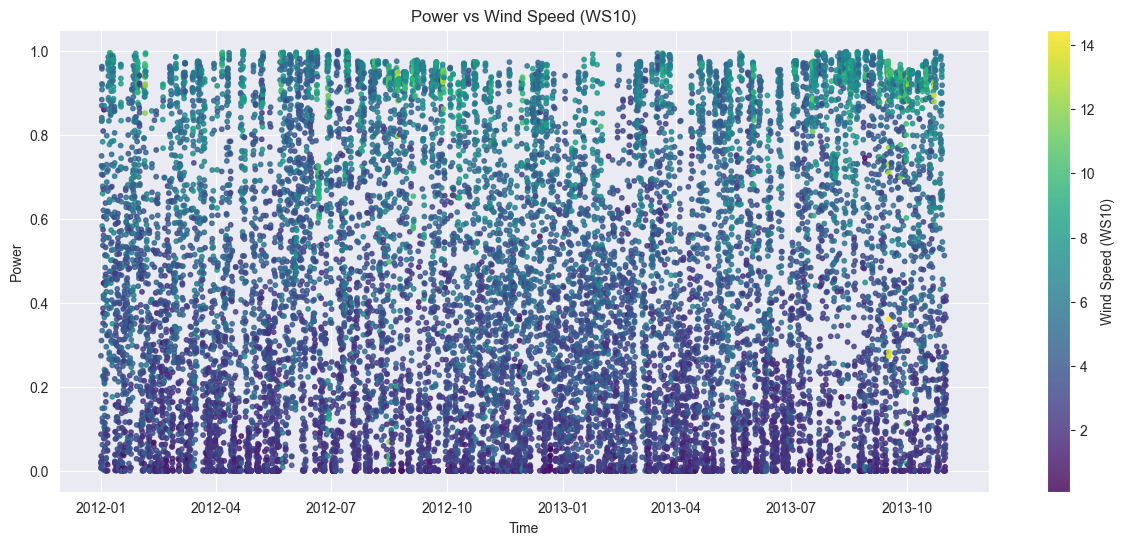

In [31]:
plt.figure(figsize=(15, 6))
scatter = plt.scatter(
    train_data['TIMESTAMP'],
    train_data['POWER'],
    c=train_data['WS10'],
    cmap='viridis',
    s=10,
    alpha=0.8
)

cbar = plt.colorbar(scatter)
cbar.set_label('Wind Speed (WS10)')
plt.title('Power vs Wind Speed (WS10)')
plt.xlabel('Time')
plt.ylabel('Power')
plt.grid(True)
plt.show()

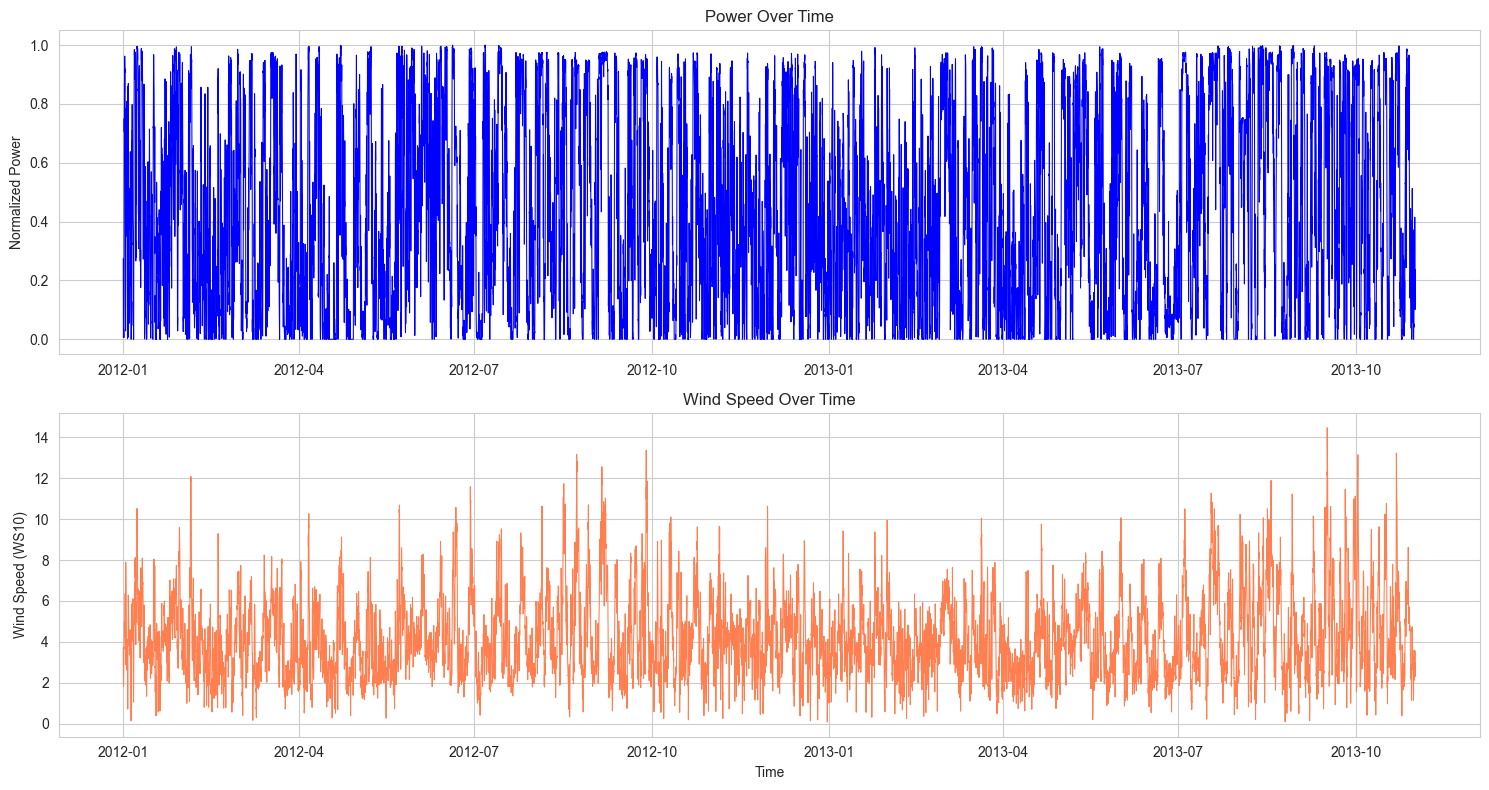

In [32]:
sns.set_style("whitegrid")
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(train_data['TIMESTAMP'], train_data['POWER'], color='blue', linewidth=0.75)
plt.title('Power Over Time')
plt.ylabel('Normalized Power')

plt.subplot(2, 1, 2)
plt.plot(train_data['TIMESTAMP'], train_data['WS10'], color='coral', linewidth=0.75)
plt.title('Wind Speed Over Time')
plt.xlabel('Time')
plt.ylabel('Wind Speed (WS10)')
plt.tight_layout()
plt.show()


### Correlation Matrix

In [33]:
# Correlation between Power, WS10, U10, and V10
correlation = train_data[['POWER', 'WS10', 'U10', 'V10']].corr()
correlation


POWER      WS10       U10       V10
POWER  1.000000  0.727077  0.298226 -0.178398
WS10   0.727077  1.000000  0.512212 -0.043980
U10    0.298226  0.512212  1.000000  0.114517
V10   -0.178398 -0.043980  0.114517  1.000000

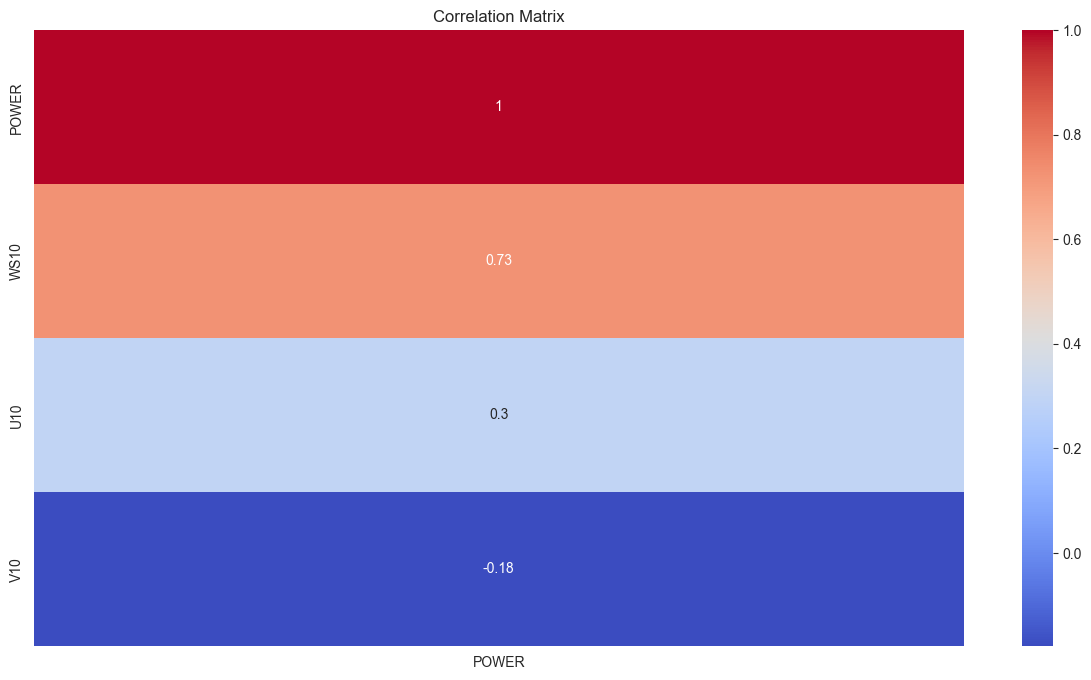

In [34]:
plt.figure(figsize=(15, 8))
sns.heatmap(correlation[['POWER']], annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

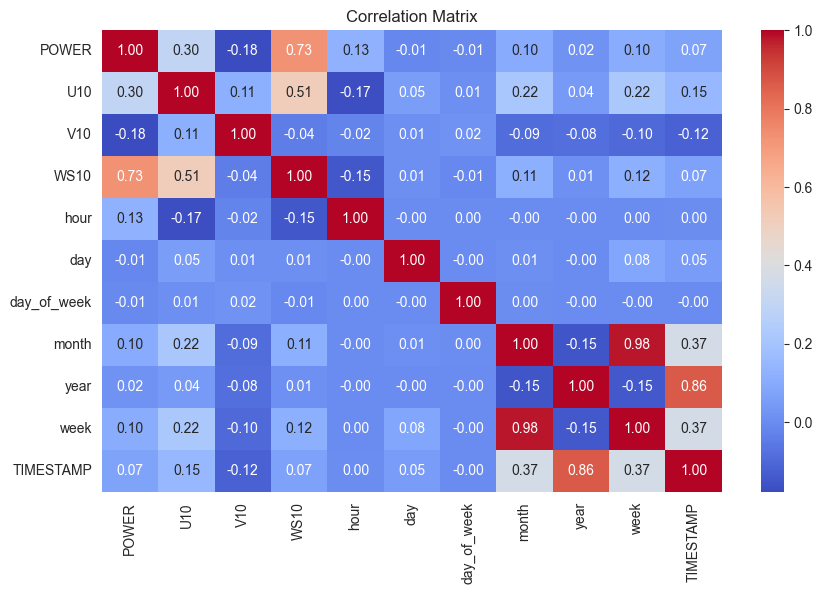

In [35]:
# Displaying the correlation matrix for all features
corr_matrix = train_data.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

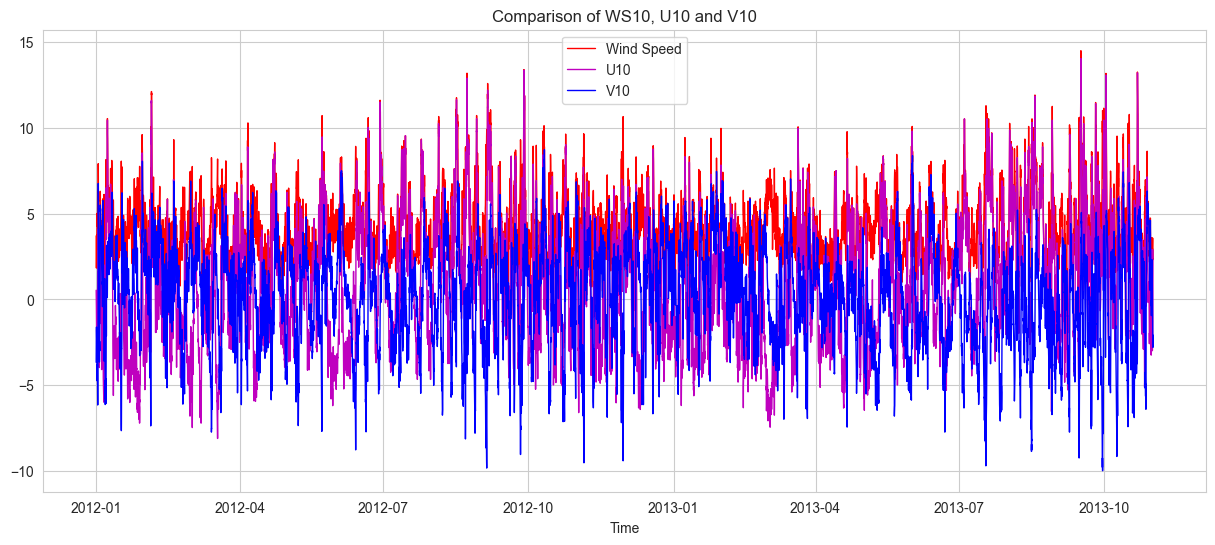

In [36]:
# Comparing WS10, U10 and V10
plt.figure(figsize=(15, 6))
plt.plot(train_data['TIMESTAMP'], train_data['WS10'], color='r', linewidth=1, label='Wind Speed')
plt.plot(train_data['TIMESTAMP'], train_data['U10'], color='m', linewidth=1, label='U10')
plt.plot(train_data['TIMESTAMP'], train_data['V10'], color='b', linewidth=1, label='V10')

plt.title('Comparison of WS10, U10 and V10')
plt.xlabel('Time')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
# Adding cyclical encoding
train_data['hour_sin'] = np.sin(2 * np.pi * train_data['hour']/24)
train_data['hour_cos'] = np.cos(2 * np.pi * train_data['hour']/24)
train_data['month_sin'] = np.sin(2 * np.pi * train_data['month']/12)
train_data['month_cos'] = np.cos(2 * np.pi * train_data['month']/12)
train_data['day_of_week_sin'] = np.sin(2 * np.pi * train_data['day_of_week'] / 7)
train_data['day_of_week_cos'] = np.cos(2 * np.pi * train_data['day_of_week'] / 7)
